In [1]:
import os
import sys
import csv
sys.path.insert(0, os.path.abspath('../'))

import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D as ax
import arrayfire as af

from dg_maxwell import params
from dg_maxwell import utils
from dg_maxwell import lagrange
from dg_maxwell import wave_equation_2d as w2d
from dg_maxwell import msh_parser
from dg_maxwell import isoparam

af.set_backend(params.backend)

gmshtranslator friendly reminder: rules and actions prototypes


def node_condition(tag,x,y,z,physgroups): 
def node_action(tag,x,y,z):
def element_condition(eletag,eletype,physgrp,nodes):
def element_action(eletag,eletype,physgrp,nodes):


/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1193: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)
/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1220: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


In [2]:
nodes, elements = msh_parser.read_order_2_msh('read_and_plot_mesh/mesh/square_1.msh')

gmshTranslator: Initializing...
gmshTranslator: Mesh has 9 nodes.
gmshTranslator: Mesh has 9 elements.
gmshTranslator: Processed 22 lines.
gmshTranslator: There are 1 physical groups available: 
gmshTranslator:      > 0
gmshTranslator: Parsing nodes
gmshTranslator: Parsing elements
gmshTranslator: No rules for elements... skipping elements.
gmshTranslator: Parsing nodes
gmshTranslator: No rules for nodes... skipping nodes.
gmshTranslator: Parsing elements


In [3]:
N_LGL   = 16

xi_LGL  = lagrange.LGL_points(N_LGL)
eta_LGL = lagrange.LGL_points(N_LGL)

Xi_LGL, Eta_LGL = utils.af_meshgrid(xi_LGL, eta_LGL)
xi_i  = af.flat(Xi_LGL)
eta_j = af.flat(Eta_LGL)

_, Lp_xi  = lagrange.lagrange_polynomials(xi_LGL)
_, Lq_eta = lagrange.lagrange_polynomials(eta_LGL)
Lp_xi = af.np_to_af_array(Lp_xi)
Lq_eta = af.np_to_af_array(Lq_eta)

dLp_dxi_coeffs  = utils.polynomial_derivative(Lp_xi)
dLq_deta_coeffs = utils.polynomial_derivative(Lq_eta)

/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1193: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)
/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1220: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


In [4]:
Lp_xi_tp = af.reorder(Lp_xi, d0 = 2, d1 = 0, d2 = 1)
Lp_xi_tp = af.tile(Lp_xi_tp, d0 = N_LGL)
Lp_xi_tp = af.moddims(Lp_xi_tp, d0 = N_LGL * N_LGL, d1 = 1, d2 = N_LGL)
Lp_xi_tp = af.reorder(Lp_xi_tp, d0 = 0, d1 = 2, d2 = 1)

Lq_eta_tp = af.reorder(Lq_eta, d0 = 0, d1 = 2, d2 = 1)
Lq_eta_tp = af.tile(Lq_eta_tp, d0 = N_LGL)
Lq_eta_tp = af.reorder(Lq_eta_tp, d0 = 0, d1 = 2, d2 = 1)

In [5]:
dLp_dxi_tp = af.reorder(dLp_dxi_coeffs, d0 = 2, d1 = 0, d2 = 1)
dLp_dxi_tp = af.tile(dLp_dxi_tp, d0 = N_LGL)
dLp_dxi_tp = af.moddims(dLp_dxi_tp, d0 = N_LGL * N_LGL, d1 = 1, d2 = N_LGL - 1)
dLp_dxi_tp = af.reorder(dLp_dxi_tp, d0 = 0, d1 = 2, d2 = 1)

dLq_deta_tp = af.reorder(dLq_deta_coeffs, d0 = 0, d1 = 2, d2 = 1)
dLq_deta_tp = af.tile(dLq_deta_tp, d0 = N_LGL)
dLq_deta_tp = af.reorder(dLq_deta_tp, d0 = 0, d1 = 2, d2 = 1)

In [6]:
dxi_dx  = w2d.dxi_dx(nodes[elements[0]][:, 0], nodes[elements[0]][:, 1], xi_i, eta_j)
dxi_dy  = w2d.dxi_dy(nodes[elements[0]][:, 0], nodes[elements[0]][:, 1], xi_i, eta_j)
deta_dx = w2d.deta_dx(nodes[elements[0]][:, 0], nodes[elements[0]][:, 1], xi_i, eta_j)
deta_dy = w2d.deta_dy(nodes[elements[0]][:, 0], nodes[elements[0]][:, 1], xi_i, eta_j)

gmshTranslator: Ending


In [7]:
def F_xi(u):
    '''
    '''
    F_xi_u = w2d.F_x(u) * dxi_dx + w2d.F_y(u) * dxi_dy

    return F_xi_u

def F_eta(u):
    '''
    '''
    F_eta_u = w2d.F_x(u) * deta_dx + w2d.F_y(u) * deta_dy
    return F_eta_u

In [8]:
def g_dd(x_nodes, y_nodes, xi, eta):
    '''
    '''
    ans00  =   (w2d.dx_dxi(x_nodes, xi, eta))**2 \
             + (w2d.dy_dxi(y_nodes, xi, eta))**2
    ans11  =   (w2d.dx_deta(x_nodes, xi, eta))**2 \
             + (w2d.dy_deta(y_nodes, xi, eta))**2
    
    ans01  =  (w2d.dx_dxi(x_nodes, xi, eta))  \
            * (w2d.dx_deta(x_nodes, xi, eta)) \
            + (w2d.dy_dxi(y_nodes, xi, eta))  \
            * (w2d.dy_deta(y_nodes, xi, eta))
    
    ans =  [[ans00, ans01],
            [ans01, ans11]
           ]
    
    return ans


def g_uu(x_nodes, y_nodes, xi, eta):
    gCov = g_dd(x_nodes, y_nodes, xi, eta)
    
    
    a = gCov[0][0]
    b = gCov[0][1]
    c = gCov[1][0]
    d = gCov[1][1]
    
    det = (a*d - b*c)
    
    ans = [[d / det, -b / det],
           [-c / det, a / det]]
    
    return ans

In [9]:
volume_integral_pq = []
for p in np.arange(N_LGL):
    for q in np.arange(N_LGL):
        # p = 0
        # q = 0
        index = p * N_LGL + q

        g_ab = g_uu(nodes[elements[0]][:, 0], nodes[elements[0]][:, 1], xi_i, eta_j)

        u_ij = np.e ** (- (xi_i**2) / (0.6 ** 2))
        u_ij_tile = af.moddims(u_ij, N_LGL, N_LGL)

        dLp_dxi_tp_ij = utils.polyval_1d(dLp_dxi_tp[index], af.np_to_af_array(np.array(xi_i)))
        dLp_dxi_tp_ij = af.transpose(dLp_dxi_tp_ij)

        Lq_eta_tp_ij = utils.polyval_1d(Lq_eta_tp[index], af.np_to_af_array(np.array(eta_j)))
        Lq_eta_tp_ij = af.transpose(Lq_eta_tp_ij)

        volume_integral_pq_ij = g_ab[0][0] * F_xi(u_ij) * Lq_eta_tp_ij * dLp_dxi_tp_ij

        volume_integrand_interpolate = w2d.lag_interpolation_2d(volume_integral_pq_ij, N_LGL)
        volume_integral_pq.append(utils.integrate_2d_multivar_poly(volume_integrand_interpolate,
                                                                   N_quad = 12, scheme = 'gauss'))
        
volume_integral_pq = af.np_to_af_array(np.array(volume_integral_pq))

/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1193: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)
/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1220: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


In [10]:
csv_handler = csv.reader(open('data_files/volume_integral_pq_2d_analytical.csv',
                              newline='\n'), delimiter=',')

content = list()

for n, line in enumerate(csv_handler):
    content.append(list())
    for item in line:
        try:
            content[-1].append(float(item))
        except ValueError:
            if content[-1] == []:
                content.pop()
                print('popping string')
            break

volume_integral_pq_analytical = af.np_to_af_array(np.array(content))

In [17]:
threshold = 1e-6
af.max(af.abs(volume_integral_pq - volume_integral_pq_analytical))
af.mean(af.abs(volume_integral_pq - volume_integral_pq_analytical))

1.423639730617627e-07

# Volume integral Convergence test

In [18]:
# Fixed N_LGL = 16

N_LGL = 16
p = 0
q = 0

index = p * N_LGL + q

g_ab = g_uu(nodes[elements[0]][:, 0], nodes[elements[0]][:, 1], xi_i, eta_j)

u_ij = np.e ** (- (xi_i**2) / (0.6 ** 2))
u_ij_tile = af.moddims(u_ij, N_LGL, N_LGL)

dLp_dxi_tp_ij = utils.polyval_1d(dLp_dxi_tp[index], af.np_to_af_array(np.array(xi_i)))
dLp_dxi_tp_ij = af.transpose(dLp_dxi_tp_ij)

Lq_eta_tp_ij = utils.polyval_1d(Lq_eta_tp[index], af.np_to_af_array(np.array(eta_j)))
Lq_eta_tp_ij = af.transpose(Lq_eta_tp_ij)

volume_integral_pq_ij = g_ab[0][0] * F_xi(u_ij) * Lq_eta_tp_ij * dLp_dxi_tp_ij

volume_integrand_interpolate = w2d.lag_interpolation_2d(volume_integral_pq_ij, N_LGL)

error = [[], []]

for n_quad in np.arange(3, 25):
    n_quad = int(n_quad)
    error[0].append(af.sum(af.abs(utils.integrate_2d_multivar_poly(volume_integrand_interpolate,
                                                                   N_quad = n_quad,
                                                                   scheme = 'gauss')
                           - volume_integral_pq_analytical[0])))
    
    error[1].append(af.sum(af.abs(utils.integrate_2d_multivar_poly(volume_integrand_interpolate,
                                                                   N_quad = n_quad,
                                                                   scheme = 'lobatto')
                           - volume_integral_pq_analytical[0])))
    
error = np.array(error)


/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1193: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)
/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1220: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


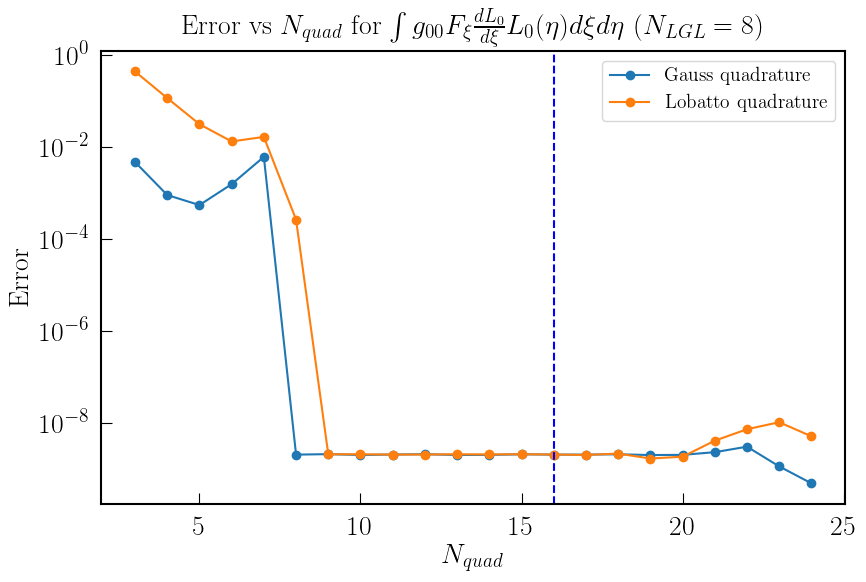

In [16]:
N_quad = np.arange(3, 25, dtype = np.float64)
plt.title(r'Error vs $N_{quad}$ for $\int g_{00} F_{\xi} \frac{dL_0}{d\xi} L_0(\eta)  d\xi d\eta$ ($N_{LGL} = 8$)')
plt.xlabel(r'$N_{quad}$')
plt.ylabel(r'Error')
plt.semilogy(N_quad, error[0], 'o-', label = r'Gauss quadrature')
plt.semilogy(N_quad, error[1], 'o-', label = r'Lobatto quadrature')
plt.axvline(x = N_LGL, color='b', linestyle='--')
# plt.axes().set_aspect('equal')
plt.legend(prop={'size': 14})
# plt.ylim(np.min(error), np.max(error) + 0.1)
plt.savefig('integrate_2d.png')
plt.show()